### Import Libraries

In [1]:
# Bibliotecas RAPIDS (GPU)
import cupy as cp
from cuml.pipeline import Pipeline as cumlPipeline
from cuml.preprocessing import StandardScaler as cumlStandardScaler
from cuml.neighbors import KNeighborsClassifier as cumlKNN
from cuml.svm import SVC as cumlSVC
from cuml.ensemble import RandomForestClassifier as cumlRF
import xgboost as xgb
from cuml.metrics import accuracy_score
from cuml.decomposition import PCA as cumlPCA

# Bibliotecas Scikit-learn (CPU)
from sklearn.preprocessing import LabelEncoder, StandardScaler as sklearnStandardScaler
from sklearn.model_selection import GroupKFold
from cuml.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix as sklearn_confusion_matrix, precision_recall_fscore_support
from sklearn.pipeline import Pipeline as sklearnPipeline
from cuml.neighbors import KNeighborsClassifier as sklearnKNN
from cuml.svm import SVC as sklearnSVC
from sklearn.ensemble import RandomForestClassifier as sklearnRF
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.base import clone 

# Bibliotecas de Utilidades
import numpy as np
import pandas as pd
import librosa
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import time
import utils
import subprocess
import io
from joblib import Parallel, delayed
import psutil

# Bibliotecas TensorFlow
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler # Necessário para o MLP na CPU/TF
import gc

# Configuração para não travar a memória da GPU com o TF, permitindo rodar junto com o RAPIDS
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-12-01 18:30:04.227570: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Audio Preprocessing

In [2]:
# --- Configuração ---
METADATA_DIR = '../fma_metadata'
AUDIO_DIR_GENRES = '../fma_datasets/fma_small_genres'
FEATURE_FILE_X = '../preprocessed_features/fma_small_windowed_X_3s_25overlap.npy'
FEATURE_FILE_y = '../preprocessed_features/fma_small_windowed_y_3s_25overlap.npy'
FEATURE_FILE_groups = '../preprocessed_features/fma_small_windowed_groups_3s_25overlap.npy'
#FEATURE_FILE_X = '../preprocessed_features/fma_small_windowed_X_3s_50overlap.npy'
#FEATURE_FILE_y = '../preprocessed_features/fma_small_windowed_y_3s_50overlap.npy'
#FEATURE_FILE_groups = '../preprocessed_features/fma_small_windowed_groups_3s_50overlap.npy'

# --- Carregar Metadados ---
tracks = utils.load(f'{METADATA_DIR}/tracks.csv')

small_mask = tracks[('set', 'subset')] == 'small'
genres_to_drop = ['International', 'Instrumental']
genre_mask = ~tracks[('track', 'genre_top')].isin(genres_to_drop)

small_mask = small_mask & genre_mask

y_all_labels_pd = tracks.loc[small_mask, ('track', 'genre_top')] # Em pandas
splits_pd = tracks.loc[small_mask, ('set', 'split')] # Em pandas

# --- Codificar os Gêneros (Labels) usando Sklearn ---
label_encoder = LabelEncoder()
# fit_transform em um pandas Series retorna um array numpy
y_all_encoded_np = label_encoder.fit_transform(y_all_labels_pd).astype(np.int32) # Converte para int32

# Criar um DataFrame pandas para referência durante a extração
track_metadata = pd.DataFrame({
    'genre_top': y_all_labels_pd,
    'genre_encoded': y_all_encoded_np,
    'split': splits_pd
}, index=y_all_labels_pd.index)

# Obter nomes das classes para posterior plotagem
class_names = label_encoder.classes_

print(f"Metadados carregados para {track_metadata.shape[0]} faixas 'small'.")
print(f"Gêneros: {class_names}")

Metadados carregados para 6000 faixas 'small'.
Gêneros: ['Electronic' 'Experimental' 'Folk' 'Hip-Hop' 'Pop' 'Rock']


In [3]:
def calculate_stats(features_matrix):
    """
    Calcula apenas Mean e Std para evitar instabilidade e ruído em janelas curtas.
    """
    result = []
    
    # Garantir que a matriz não esteja vazia
    if features_matrix.size == 0:
        return None 

    # 1. mean
    result.extend(np.mean(features_matrix, axis=1))
    # 2. std
    result.extend(np.std(features_matrix, axis=1))
    # 3. skew
    result.extend(stats.skew(features_matrix, axis=1))
    # 4. kurtosis
    result.extend(stats.kurtosis(features_matrix, axis=1))
    # 5. median
    #result.extend(np.median(features_matrix, axis=1))
    # 6. min
    #result.extend(np.min(features_matrix, axis=1))
    # 7. max
    #result.extend(np.max(features_matrix, axis=1))
    
    return np.array(result)

def load_audio_ffmpeg(file_path, sr):
    """
    Carrega áudio usando ffmpeg diretamente para evitar erros de cabeçalho MP3
    que o librosa/audioread falham em ler.
    """
    try:
        # Comando ffmpeg para decodificar para WAV na saída padrão (pipe)
        # -i: entrada
        # -f wav: formato wav
        # -ac 1: mono
        # -ar: sample rate
        # -vn: sem vídeo
        # -: saída para stdout
        command = [
            'ffmpeg', 
            '-i', file_path, 
            '-f', 'wav', 
            '-ac', '1', 
            '-ar', str(sr), 
            '-vn', 
            '-y',  # sobrescrever (não deve ser necessário para pipe, mas boa prática)
            '-loglevel', 'panic', # Silenciar logs
            '-'
        ]
        
        # Executa o comando
        out = subprocess.check_output(command)
        
        # Carrega o buffer de bytes com librosa
        # io.BytesIO transforma os bytes do ffmpeg em um "arquivo em memória"
        y, _ = librosa.load(io.BytesIO(out), sr=sr)
        return y
        
    except Exception as e:
        # Fallback: se ffmpeg falhar (arquivo inexistente ou muito corrompido), tenta librosa puro
        try:
            y, _ = librosa.load(file_path, sr=sr, mono=True)
            return y
        except:
            return None

def extract_features_windowed_full(file_path, window_size_sec, overlap_percent, sr):
    """
    Extrai o conjunto completo de 518 features para cada janela de Ns.
    Esta função é uma adaptação de 'compute_features' de features.py,
    MODIFICADA para aceitar janelas com sobreposição, extração robusta com FFmpeg e obtenção estatísticas simplificadas.
    """
    
    all_window_features = []
    
    # Parâmetros do librosa (como em features.py e baselines.ipynb)
    N_FFT = 2048
    HOP_LENGTH = 512
    N_MFCC = 20
    N_CHROMA = 12
    N_CONTRAST = 7
    
    try:
        # 1. Carregamento
        y = load_audio_ffmpeg(file_path, sr=sr)
        
        if y is None or len(y) == 0:
            return None
        
        # 2. Janelamento
        samples_per_window = window_size_sec * sr
        hop_size = int(samples_per_window * (1.0 - overlap_percent))
        
        # Garante que o áudio tenha pelo menos o tamanho de uma janela
        if len(y) < samples_per_window:
            print(f"Aviso: Áudio {file_path} mais curto que {window_size_sec}s. Pulando.")
            return None

        # Cria as janelas (frames) com sobreposição
        # axis=0 torna y_frames [n_windows, samples_per_window]
        y_frames = librosa.util.frame(y, frame_length=samples_per_window, hop_length=hop_size, axis=0)
        
        # Itera sobre as janelas (frames) para extração
        for y_window in y_frames:
            # STFT e CQT (bases para muitas features)
            stft = np.abs(librosa.stft(y_window, n_fft=N_FFT, hop_length=HOP_LENGTH))
            cqt = np.abs(librosa.cqt(y_window, sr=sr, hop_length=HOP_LENGTH))
            
            window_vector = []
            
            # 1. ZCR
            f = librosa.feature.zero_crossing_rate(y_window, frame_length=N_FFT, hop_length=HOP_LENGTH)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 2. Chroma CQT
            f = librosa.feature.chroma_cqt(C=cqt, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 3. Chroma CENS
            f = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 4. Chroma STFT
            f = librosa.feature.chroma_stft(S=stft**2, n_chroma=N_CHROMA)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 5. RMSE
            f = librosa.feature.rms(S=stft) # Nota: features.py usa 'rmse', mas 'rms' é a função atual
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 6. Spectral Centroid
            f = librosa.feature.spectral_centroid(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 7. Spectral Bandwidth
            f = librosa.feature.spectral_bandwidth(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 8. Spectral Contrast (7 * 7 = 49 features)
            f = librosa.feature.spectral_contrast(S=stft, n_bands=N_CONTRAST - 1)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)

            # 9. Spectral Rolloff (1 * 7 = 7 features)
            f = librosa.feature.spectral_rolloff(S=stft)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 10. MFCC (20 * 7 = 140 features)
            # Primeiro calculamos o espectrograma Mel e em seguida os MFCCs base
            mel = librosa.feature.melspectrogram(S=stft**2, sr=sr)
            mfcc = librosa.feature.mfcc(S=librosa.power_to_db(mel), n_mfcc=N_MFCC)

            # Delta (primeira derivada temporal)
            mfcc_delta = librosa.feature.delta(mfcc)

            # Delta-Delta (segunda derivada temporal)
            mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

            # 10.1 MFCC Original
            stats_f = calculate_stats(mfcc)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 10.2 MFCC Delta
            stats_f = calculate_stats(mfcc_delta)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 10.3 MFCC Delta-Delta
            stats_f = calculate_stats(mfcc_delta2)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # 11. Tonnetz (6 * 7 = 42 features)
            # (Calculado por último, pois pode depender do chroma_cens)
            f_chroma_cens = librosa.feature.chroma_cens(C=cqt, n_chroma=N_CHROMA) # Recalcula se necessário
            f = librosa.feature.tonnetz(y=librosa.effects.harmonic(y_window), sr=sr, chroma=f_chroma_cens)
            stats_f = calculate_stats(f)
            if stats_f is None: continue
            window_vector.extend(stats_f)
            
            # Adicionar o vetor completo
            all_window_features.append(window_vector)
            
    except Exception as e:
        print(f"Erro ao processar {file_path}: {e}")
        return None # Retorna None em caso de erro de carregamento/processamento
        
    return all_window_features

In [4]:
def process_track(track_id, genre_top, genre_encoded, audio_dir, params):
    """
    Função worker que será executada em paralelo.
    Processa uma única faixa e retorna uma lista de vetores (janelas).
    """
    # Desempacotar parâmetros para não passar argumentos demais
    window_size = params['window_size']
    overlap = params['overlap']
    sr = params['sr']
    
    file_path = f"{audio_dir}/{genre_top}/{track_id:06d}.mp3"
    
    if not os.path.exists(file_path):
        return None

    # Reaproveitando sua função de extração (que já está definida no notebook)
    # Nota: Certifique-se que 'extract_features_windowed_full' está definida antes desta célula
    try:
        # A função original retorna uma lista de listas (várias janelas por música)
        window_vectors = extract_features_windowed_full(
            file_path, 
            window_size_sec=window_size, 
            overlap_percent=overlap, 
            sr=sr
        )
        
        if window_vectors is None or len(window_vectors) == 0:
            return None
            
        # Preparar o retorno estruturado para facilitar a montagem depois
        # Retorna: (Lista de Features, Lista de Labels, Lista de TrackIDs)
        labels = [genre_encoded] * len(window_vectors)
        track_ids = [track_id] * len(window_vectors)
        
        return window_vectors, labels, track_ids

    except Exception as e:
        print(f"Erro crítico na track {track_id}: {e}")
        return None

In [5]:
# Parâmetros de Extração
extraction_params = {
    'window_size': 3,
    'overlap': 0.25,
    'sr': 22050
}

# Verifica se precisa rodar
if not (os.path.exists(FEATURE_FILE_X) and 
        os.path.exists(FEATURE_FILE_y) and 
        os.path.exists(FEATURE_FILE_groups)):
    
    print(f"Iniciando extração paralela em {AUDIO_DIR_GENRES}...")
    
    # 1. Preparar a lista de tarefas
    # Em vez de processar, criamos uma lista de argumentos para passar aos workers
    tasks = []
    # track_metadata deve ter sido carregado anteriormente no notebook
    for track_id, row in track_metadata.iterrows():
        tasks.append((track_id, row['genre_top'], row['genre_encoded']))
        
    # 2. Configurar paralelismo
    # Usa o psutil para contar núcleos físicos (não lógicos/threads)
    # Isso geralmente oferece melhor performance para tarefas pesadas de DSP
    physical_cores = psutil.cpu_count(logical=False)

    # n_jobs=-1 usa todos os cores. n_jobs=-2 usa todos menos 1 (para deixar o OS responsivo)
    # Reserva-se 1 ou 2 núcleos para o sistema operacional não travar
    n_cores = max(1, physical_cores - 1)
    print(f"Utilizando {n_cores} núcleos da CPU para processar {len(tasks)} faixas.")
    
    # 3. Executar em Paralelo
    # O tqdm aqui vai mostrar a barra de progresso baseada na conclusão das tarefas
    results = Parallel(n_jobs=n_cores, verbose=0)(
        delayed(process_track)(
            t_id, g_top, g_enc, AUDIO_DIR_GENRES, extraction_params
        ) for t_id, g_top, g_enc in tqdm(tasks, desc="Extraindo Features")
    )
    
    # 4. Consolidar Resultados
    print("Consolidando dados...")
    all_features = []
    all_labels = []
    all_track_ids = []
    
    for res in results:
        if res is not None:
            feats, lbls, tids = res
            all_features.extend(feats)
            all_labels.extend(lbls)
            all_track_ids.extend(tids)
            
    # 5. Salvar (Lógica original mantida)
    if len(all_features) > 0:
        X_np = np.array(all_features)
        y_encoded_np = np.array(all_labels, dtype=np.int32)
        groups_np = np.array(all_track_ids, dtype=np.int32)
        
        # Limpeza de NaNs
        X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)

        print(f"Extração concluída!")
        print(f"Total de amostras (janelas) para CV: {X_np.shape[0]}")
        print(f"Total de grupos (faixas únicas): {len(np.unique(groups_np))}")
        print(f"Total de features: {X_np.shape[1]}")
        print(f"Tipo de dado das features (X): {X_np.dtype}")
        print(f"Tipo de dado das labels (y): {y_encoded_np.dtype}")
        print(f"Tipo de dado dos grupos (groups): {groups_np.dtype}")
        print(f"Salvando em {FEATURE_FILE_X}...")
        
        os.makedirs(os.path.dirname(FEATURE_FILE_X), exist_ok=True)
        np.save(FEATURE_FILE_X, X_np)
        np.save(FEATURE_FILE_y, y_encoded_np)
        np.save(FEATURE_FILE_groups, groups_np)
    else:
        print("\nExtração falhou. Nenhuma feature foi extraída. Verifique se o 'ffmpeg' está instalado.")
        X_np = np.array([])
        y_encoded_np = np.array([], dtype=np.int32)
        groups_np = np.array([], dtype=np.int32)

else:
    print(f"Arquivos encontrados. Carregando de {FEATURE_FILE_X}...")
    X_np = np.load(FEATURE_FILE_X)
    y_encoded_np = np.load(FEATURE_FILE_y)
    groups_np = np.load(FEATURE_FILE_groups)

    valid_tracks_set = set(track_metadata.index)

    print("Filtrando dados e regenerando rótulos para os 6 gêneros...")
    # 1. Identificar quais janelas pertencem às faixas permitidas
    # track_metadata contém apenas as faixas dos 6 gêneros (definido na Célula 2)
    valid_tracks_set = set(track_metadata.index)

    # Cria uma máscara: Mantém apenas janelas cujo TrackID está no metadata filtrado
    mask = np.isin(groups_np, list(valid_tracks_set))

    # 2. Filtrar X e Groups
    X_np = X_np[mask]
    groups_np = groups_np[mask]

    # 3. REGENERAR O Y (Rótulos)
    # Mapeia: TrackID -> Novo Label (0-5)
    # Isso garante que o rótulo da janela corresponda ao novo LabelEncoder
    tid_to_label = track_metadata['genre_encoded'].to_dict()

    # Constrói o vetor y usando o dicionário
    y_encoded_np = np.array([tid_to_label[tid] for tid in groups_np], dtype=np.int32)

    # Limpeza de segurança
    X_np = np.nan_to_num(X_np, nan=0.0, posinf=0.0, neginf=0.0)
    
    print("Dados carregados.")

Arquivos encontrados. Carregando de ../preprocessed_features/fma_small_windowed_X_3s_25overlap.npy...
Filtrando dados e regenerando rótulos para os 6 gêneros...
Dados carregados.


### Treino dos Modelos

In [6]:
# Converta para float32 para economizar RAM e VRAM
X_final = X_np.astype(np.float32)
y_encoded_np = y_encoded_np.astype(np.int32)

In [7]:
def build_reference_mlp(input_shape, num_classes):
    l2_reg = 0.001  # Peso da regularização L2 (ajuda a evitar pesos muito grandes)
    dropout_rate = 0.3 # Um pouco menor que 0.4, pois teremos BatchNormalization
    
    model = keras.Sequential([
        layers.Input(shape=(input_shape,)),
        
        # --- Bloco D denso 1 (Expansão) ---
        # HeNormal é a melhor inicialização para redes baseadas em ReLU/ELU
        layers.Dense(512, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(), # Normaliza a ativação (crucial para convergência rápida)
        layers.ELU(),                # ELU (Exponential Linear Unit) costuma superar ReLU em áudio
        layers.Dropout(dropout_rate),

        # --- Bloco D denso 2 (Compressão Gradual) ---
        layers.Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # --- Bloco D denso 3 ---
        layers.Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        layers.Dropout(dropout_rate),
        
        # --- Bloco D denso 4 (Refinamento) ---
        layers.Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(l2_reg)),
        layers.BatchNormalization(),
        layers.ELU(),
        
        # --- Saída ---
        layers.Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')
    ])
    
    # Otimizador AdamW (Adam com Weight Decay desacoplado - Estado da Arte para generalização)
    # Requer TensorFlow Addons ou TF >= 2.10 (onde já está nativo no keras.optimizers.experimental ou normal)
    # Se der erro, use 'adam' normal, mas AdamW é melhor.
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
    
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# 1. Definir a Estratégia de CV (GroupKFold - Ponto 1)
n_splits = 10
gkf = GroupKFold(n_splits=n_splits)

# 2. Definir Modelos e Pipelines

## Pipeline para KNN (GPU)
pipe_knn = cumlPipeline([
    ('scaler', cumlStandardScaler()),
    ('knn', cumlKNN(n_neighbors=5))
])

## Pipeline para SVM (CPU)
pipe_svm = cumlPipeline([
    ('scaler', cumlStandardScaler()),
    ('svm', cumlSVC(kernel='rbf', 
                       C=1.0, 
                       decision_function_shape="ovo")) 
])

## Pipeline para Random Forest (GPU)
pipe_rf_gpu = cumlPipeline([
    ('rf', cumlRF(
        n_estimators=250,   # Seu parâmetro desejado
        max_depth=50,        # Seu parâmetro desejado
        random_state=42,
        n_streams=1
    ))
])

## XGBoost (GPU)
pipe_xgb_gpu = cumlPipeline([
    ('xgb', xgb.XGBClassifier(
        n_estimators=1000,     # Número de árvores (pode tunar depois)
        max_depth=6,           # Profundidade máxima (evita overfitting)
        learning_rate=0.05,    # Taxa de aprendizado
        tree_method='hist',    # USA A GPU (RTX 3060)
        device = "cuda",
        random_state=42,
        objective='multi:softmax', # Classificação multiclasse
        num_class=len(class_names) # Número de classes (gêneros)
    ))
])

models = {
    "KNN (GPU)": pipe_knn,
    "SVM (GPU)": pipe_svm,
    "Random Forest (GPU)": pipe_rf_gpu,
    "XGBoost (GPU)": pipe_xgb_gpu,
    "MLP (Keras)": "keras_model_placeholder"
}

# Dicionários para guardar os resultados (Nível da Faixa)
cv_scores_track = {}
out_of_fold_preds_track = {}

# 3. Executar a Validação Cruzada (GroupKFold + Votação Majoritária)
for model_name, model_template in models.items():
    print(f"\nIniciando CV {n_splits}-Fold para {model_name}...")
    start_model_time = time.time()
    
    fold_scores_acc = []
    fold_scores_precision = []
    fold_scores_recall = []
    fold_scores_f1 = []

    all_preds_for_model = []
    all_true_for_model = []

    # [IMPORTANTE] Clonar o modelo para não carregar lixo de execuções anteriores
    # Se for uma string (como o placeholder do Keras), não clonamos
    if model_name != "MLP (Keras)":
        model = clone(model_template)
    else:
        model = model_template

    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_final, y_encoded_np, groups=groups_np)):
        
        # Índices são numpy
        X_train_np_fold = X_final[train_idx]
        y_train_np_fold = y_encoded_np[train_idx]
        X_test_np_fold = X_final[test_idx]
        y_true_window_np = y_encoded_np[test_idx]
        track_ids_test_fold = groups_np[test_idx]

        # LÓGICA PARA O MLP (KERAS)
        if model_name == "MLP (Keras)":
            # 1. Normalização (Essencial para Redes Neurais)
            # Ajustamos o scaler apenas no treino e aplicamos no teste
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_np_fold)
            X_test_scaled = scaler.transform(X_test_np_fold)

            # 2. Aplicação do PCA (usando cuML para velocidade)
            # Nota: É mais rápido converter para GPU (cupy), rodar PCA e voltar se necessário,
            # mas o MLP do Keras aceita numpy.
            pca = cumlPCA(n_components=150)
            
            # O PCA do cuML espera dados na GPU ou numpy (ele gerencia internamente)
            X_train_pca = pca.fit_transform(X_train_scaled)
            X_test_pca = pca.transform(X_test_scaled)

            # IMPORTANTE: O input_shape muda de ~454 para o número de componentes do PCA (ex: ~80)
            input_dim = X_train_pca.shape[1]
            
            # 2. Construir o modelo do zero para cada fold
            # O input_shape é dinâmico baseado nas suas features
            keras_model = build_reference_mlp(input_dim, len(class_names))
            
            # 3. Callbacks para parar se não estiver aprendendo (Early Stopping)
            callbacks_list = [
                # Para se o modelo não melhorar por 8 épocas (evita desperdício)
                EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
                
                # Reduz a taxa de aprendizado se o modelo estagnar (O "Pulo do Gato")
                # Se o loss não cair por 3 épocas, divide o LR por 5. 
                # Isso ajuda o modelo a descer o "vale" do mínimo global com passos menores.
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', 
                    factor=0.2, 
                    patience=3, 
                    min_lr=1e-6,
                    verbose=1
                )
            ]

            # 4. Treino
            # Usamos 10% do treino como validação interna para o Early Stopping
            history = keras_model.fit(
                X_train_pca, y_train_np_fold,
                epochs=60,           # Pode aumentar se o early stopping estiver ativo
                batch_size=16,       # Padrão do classificador de voz
                validation_split=0.1,
                callbacks=callbacks_list,
                verbose=0            # 0 para não poluir o notebook
            )
            
            # 5. Predição
            y_pred_probs = keras_model.predict(X_test_pca, verbose=0)
            y_pred_window_np = np.argmax(y_pred_probs, axis=1) # Converte probab. para classe
            
            # Limpeza de memória do TF
            tf.keras.backend.clear_session()
            del keras_model, X_train_scaled, X_test_scaled, X_train_pca, X_test_pca, pca

        # LÓGICA PARA MODELOS DE GPU (RAPIDS/XGBOOST)
        elif "GPU" in model_name:
            # --- Bloco GPU (cuML) ---
            X_train_cp = cp.array(X_train_np_fold)
            y_train_cp = cp.array(y_train_np_fold, dtype=cp.int32)
            X_test_cp = cp.array(X_test_np_fold)
            
            model.fit(X_train_cp, y_train_cp)
            
            y_pred_cp = model.predict(X_test_cp)
            
            y_pred_window_np = cp.asnumpy(y_pred_cp) # De volta para CPU
            
            del X_train_cp, y_train_cp, X_test_cp, y_pred_cp # Limpa VRAM
            cp.get_default_memory_pool().free_all_blocks() # Limpa cache do CuPy
        else:
            # --- Bloco CPU (Sklearn) ---
            # 'model' aqui é o pipe_rf_cpu do sklearn
            model.fit(X_train_np_fold, y_train_np_fold)
            y_pred_window_np = model.predict(X_test_np_fold) # Já está em NumPy

        
        # --- Agregação (PONTO 2: Votação Majoritária) ---
        # (Esta parte é sempre na CPU)
        
        df_fold = pd.DataFrame({
            'track_id': track_ids_test_fold,
            'y_true_window': y_true_window_np,
            'y_pred_window': y_pred_window_np
        })

        grouped = df_fold.groupby('track_id')
        y_true_track = grouped['y_true_window'].first()
        y_pred_track = grouped['y_pred_window'].apply(lambda x: stats.mode(x, keepdims=True)[0][0])
        
        acc_fold_track = accuracy_score(y_true_track, y_pred_track)
        fold_scores_acc.append(acc_fold_track)

        # Calculo dos precision_recall_fscore_support
        macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(y_true_track, y_pred_track, average='macro', zero_division=0)

        # Converter métricas scalarem de volta para CPU/float para armazenar na lista
        fold_scores_precision.append(float(macro_p))
        fold_scores_recall.append(float(macro_r))
        fold_scores_f1.append(float(macro_f1))

        all_preds_for_model.append(y_pred_track.values)
        all_true_for_model.append(y_true_track.values)
        
        gc.collect()
    
    # --- Fim do Loop CV ---
    
    cv_scores_track[model_name] = {
        'Acurácia (Nível Faixa)': np.array(fold_scores_acc),
        'Precisão': np.array(fold_scores_precision),
        'Recall': np.array(fold_scores_recall),
        'F1-Score': np.array(fold_scores_f1)
    } 
    
    y_true_final = np.concatenate(all_true_for_model)
    y_pred_final = np.concatenate(all_preds_for_model)
    
    out_of_fold_preds_track[model_name] = {
        'y_true': y_true_final,
        'y_pred': y_pred_final
    }

    print(f"Limpando memória de {model_name}...")
    del model
    gc.collect()
    if "GPU" in model_name:
        cp.get_default_memory_pool().free_all_blocks()
        cp.get_default_pinned_memory_pool().free_all_blocks()
    
    end_model_time = time.time()
    print(f"Treinamento de {model_name} concluído em {end_model_time - start_model_time:.2f} segundos.")


print("\n--- Treinamento e Avaliação de CV (Nível Faixa) Concluídos ---")


Iniciando CV 10-Fold para Random Forest (GPU)...
Limpando memória de Random Forest (GPU)...
Treinamento de Random Forest (GPU) concluído em 114.67 segundos.

Iniciando CV 10-Fold para KNN (GPU)...
[2025-12-01 18:32:08.465] [CUML] [info] Unused keyword parameter: n_jobs during cuML estimator initialization
Limpando memória de KNN (GPU)...
Treinamento de KNN (GPU) concluído em 8.55 segundos.

Iniciando CV 10-Fold para SVM (GPU)...
Limpando memória de SVM (GPU)...
Treinamento de SVM (GPU) concluído em 79.80 segundos.

Iniciando CV 10-Fold para XGBoost (GPU)...
Limpando memória de XGBoost (GPU)...
Treinamento de XGBoost (GPU) concluído em 1182.59 segundos.

Iniciando CV 10-Fold para MLP (Keras)...

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 22: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 27: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 1.600

### Análise de Resultados


========= Resultados Random Forest (GPU) (10-Fold CV) - Nível Faixa (Votação Majoritária) ==========
--- Acurácia (Nível Faixa) ---
  Média        : 0.5984
  Desv. Padrão : 0.0213
  Scores (por Fold): [0.608 0.564 0.622 0.565 0.625 0.587 0.599 0.623 0.606 0.586]
--- Precisão ---
  Média        : 0.5916
  Desv. Padrão : 0.0210
  Scores (por Fold): [0.606 0.56  0.616 0.558 0.618 0.578 0.598 0.608 0.599 0.576]
--- Recall ---
  Média        : 0.5995
  Desv. Padrão : 0.0178
  Scores (por Fold): [0.611 0.579 0.624 0.57  0.629 0.595 0.59  0.609 0.6   0.587]
--- F1-Score ---
  Média        : 0.5886
  Desv. Padrão : 0.0196
  Scores (por Fold): [0.602 0.557 0.609 0.557 0.615 0.581 0.587 0.605 0.597 0.577]

========= Resultados KNN (GPU) (10-Fold CV) - Nível Faixa (Votação Majoritária) ==========
--- Acurácia (Nível Faixa) ---
  Média        : 0.5589
  Desv. Padrão : 0.0198
  Scores (por Fold): [0.563 0.556 0.597 0.542 0.55  0.533 0.551 0.579 0.581 0.538]
--- Precisão ---
  Média        : 0.5705

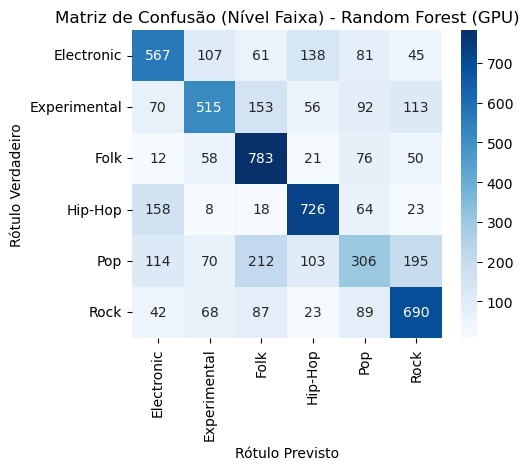


--- Relatório de Classificação (Nível Faixa) ---
              precision    recall  f1-score   support

  Electronic       0.59      0.57      0.58       999
Experimental       0.62      0.52      0.56       999
        Folk       0.60      0.78      0.68      1000
     Hip-Hop       0.68      0.73      0.70       997
         Pop       0.43      0.31      0.36      1000
        Rock       0.62      0.69      0.65       999

    accuracy                           0.60      5994
   macro avg       0.59      0.60      0.59      5994
weighted avg       0.59      0.60      0.59      5994

--- KNN (GPU) ---


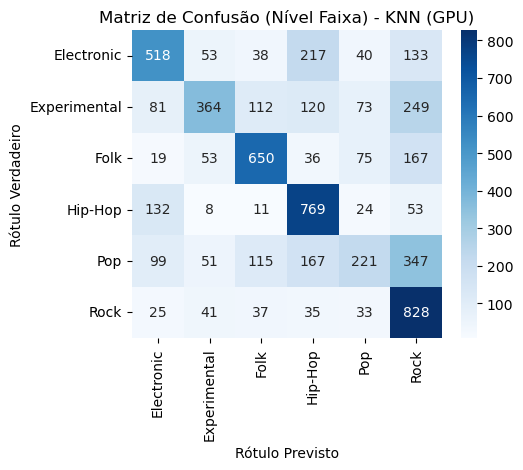


--- Relatório de Classificação (Nível Faixa) ---
              precision    recall  f1-score   support

  Electronic       0.59      0.52      0.55       999
Experimental       0.64      0.36      0.46       999
        Folk       0.67      0.65      0.66      1000
     Hip-Hop       0.57      0.77      0.66       997
         Pop       0.47      0.22      0.30      1000
        Rock       0.47      0.83      0.60       999

    accuracy                           0.56      5994
   macro avg       0.57      0.56      0.54      5994
weighted avg       0.57      0.56      0.54      5994

--- SVM (GPU) ---


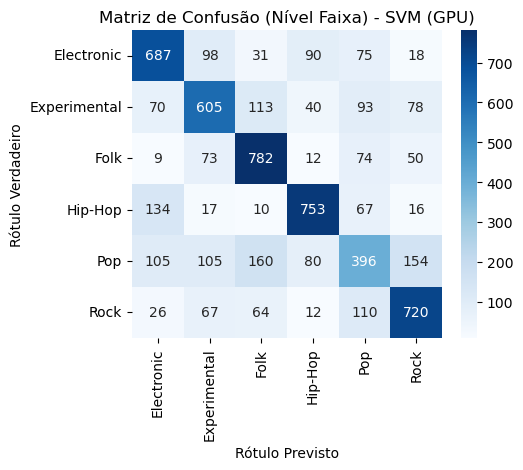


--- Relatório de Classificação (Nível Faixa) ---
              precision    recall  f1-score   support

  Electronic       0.67      0.69      0.68       999
Experimental       0.63      0.61      0.62       999
        Folk       0.67      0.78      0.72      1000
     Hip-Hop       0.76      0.76      0.76       997
         Pop       0.49      0.40      0.44      1000
        Rock       0.69      0.72      0.71       999

    accuracy                           0.66      5994
   macro avg       0.65      0.66      0.65      5994
weighted avg       0.65      0.66      0.65      5994

--- XGBoost (GPU) ---


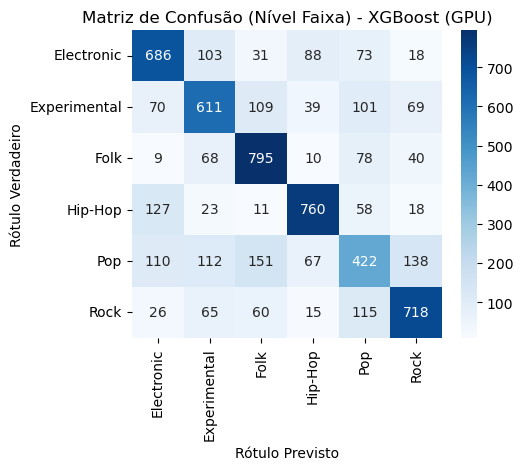


--- Relatório de Classificação (Nível Faixa) ---
              precision    recall  f1-score   support

  Electronic       0.67      0.69      0.68       999
Experimental       0.62      0.61      0.62       999
        Folk       0.69      0.80      0.74      1000
     Hip-Hop       0.78      0.76      0.77       997
         Pop       0.50      0.42      0.46      1000
        Rock       0.72      0.72      0.72       999

    accuracy                           0.67      5994
   macro avg       0.66      0.67      0.66      5994
weighted avg       0.66      0.67      0.66      5994

--- MLP (Keras) ---


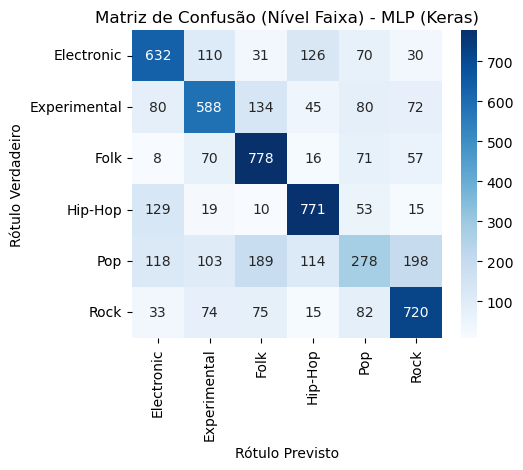


--- Relatório de Classificação (Nível Faixa) ---
              precision    recall  f1-score   support

  Electronic       0.63      0.63      0.63       999
Experimental       0.61      0.59      0.60       999
        Folk       0.64      0.78      0.70      1000
     Hip-Hop       0.71      0.77      0.74       997
         Pop       0.44      0.28      0.34      1000
        Rock       0.66      0.72      0.69       999

    accuracy                           0.63      5994
   macro avg       0.61      0.63      0.62      5994
weighted avg       0.61      0.63      0.62      5994



In [9]:
# 4. Analisar Resultados (Relatório de Métricas Nível Faixa)
for model_name, metrics in cv_scores_track.items():
    print(f"\n========= Resultados {model_name} ({n_splits}-Fold CV) - Nível Faixa (Votação Majoritária) ==========")
    
    for metric_name, scores_cpu in metrics.items():
        print(f"--- {metric_name} ---")
        print(f"  Média        : {scores_cpu.mean():.4f}")
        print(f"  Desv. Padrão : {scores_cpu.std():.4f}")
        print(f"  Scores (por Fold): {np.round(scores_cpu, 3)}")

# 5. Análise (Matrizes de Confusão Nível Faixa)
print("\n\n========= Matrizes de Confusão (Agregadas da CV) - Nível Faixa ==========")

for model_name, results in out_of_fold_preds_track.items():
    print(f"--- {model_name} ---")
    
    y_true_agg = results['y_true']
    y_pred_agg = results['y_pred']
    
    cm_cpu = sklearn_confusion_matrix(y_true_agg, y_pred_agg)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_cpu, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão (Nível Faixa) - {model_name}')
    plt.ylabel('Rótulo Verdadeiro')
    plt.xlabel('Rótulo Previsto')
    plt.show()
    
    print("\n--- Relatório de Classificação (Nível Faixa) ---")
    print(classification_report(y_true_agg, y_pred_agg, target_names=class_names))